In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import plotly.express as px 
import plotly.io as pio
from scipy.stats import zscore
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from scipy.stats import chi2_contingency
import prince
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Importando o banco de dados

casas = pd.read_excel('data/preco_casas_completo.xlsx')
## Fonte: https://www.kaggle.com/datasets/elakiricoder/jiffs-house-price-prediction-datasetchart

In [3]:
# Vamos separar o banco de dados com variáveis qualitativas

casas_quali = casas[['large_living_room', 
                     'parking_space', 
                     'front_garden',
                     'swimming_pool',
                     'wall_fence',
                     'water_front',
                     'room_size_class']]

In [4]:
# Tabelas de frequências das variáveis

print(casas_quali['large_living_room'].value_counts())
print(casas_quali['parking_space'].value_counts())
print(casas_quali['front_garden'].value_counts())
print(casas_quali['swimming_pool'].value_counts())
print(casas_quali['wall_fence'].value_counts())
print(casas_quali['water_front'].value_counts())
print(casas_quali['room_size_class'].value_counts())

large_living_room
Yes    3586
No     1368
Name: count, dtype: int64
parking_space
Yes    3784
No     1170
Name: count, dtype: int64
front_garden
Yes    3109
No     1845
Name: count, dtype: int64
swimming_pool
Yes    3060
No     1894
Name: count, dtype: int64
wall_fence
Yes    3123
No     1831
Name: count, dtype: int64
water_front
No     4713
Yes     241
Name: count, dtype: int64
room_size_class
Two      1779
One      1460
Three    1198
Zero      517
Name: count, dtype: int64


In [5]:
# Testes qui-quadrado para associação

# Para simplificar, vamos colocar 'large_living_room' como referência
# Vamos testar todas as associações com 'large_living_room'
# Se alguma não passar, avaliaremos com outra variável

tabela_mca_1 = chi2_contingency(pd.crosstab(casas_quali['large_living_room'], casas_quali['parking_space']))
tabela_mca_2 = chi2_contingency(pd.crosstab(casas_quali['large_living_room'], casas_quali['front_garden']))
tabela_mca_3 = chi2_contingency(pd.crosstab(casas_quali['large_living_room'], casas_quali['swimming_pool']))
tabela_mca_4 = chi2_contingency(pd.crosstab(casas_quali['large_living_room'], casas_quali['wall_fence']))
tabela_mca_5 = chi2_contingency(pd.crosstab(casas_quali['large_living_room'], casas_quali['water_front']))
tabela_mca_6 = chi2_contingency(pd.crosstab(casas_quali['large_living_room'], casas_quali['room_size_class']))

print(f"p-valor da estatística: {round(tabela_mca_1[1], 4)}")
print(f"p-valor da estatística: {round(tabela_mca_2[1], 4)}")
print(f"p-valor da estatística: {round(tabela_mca_3[1], 4)}")
print(f"p-valor da estatística: {round(tabela_mca_4[1], 4)}")
print(f"p-valor da estatística: {round(tabela_mca_5[1], 4)}")
print(f"p-valor da estatística: {round(tabela_mca_6[1], 4)}")

p-valor da estatística: 0.0
p-valor da estatística: 0.0
p-valor da estatística: 0.0
p-valor da estatística: 0.0
p-valor da estatística: 0.0031
p-valor da estatística: 0.0


In [6]:
# Elaborando a ACM

# Antes de elaborar a ACM, vamos retirar os "_" nos nomes das variáveis
# É um procedimento operacional para facilitar a geração do mapa perceptual 
casas_quali.columns = casas_quali.columns.str.replace("_", "-") 

# Elaborando a ACM
mca = prince.MCA(n_components=2).fit(casas_quali)

In [7]:
# Obtendo os autovalores

tabela_autovalores = mca.eigenvalues_summary
print(tabela_autovalores)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.354        27.50%                     27.50%
1              0.146        11.36%                     38.86%


In [8]:
# Obtendo as coordenadas-padrão das categorias das variáveis

coord_padrao = mca.column_coordinates(casas_quali)/np.sqrt(mca.eigenvalues_)
print(coord_padrao)

                               0         1
large-living-room__No   1.642017 -0.250120
large-living-room__Yes -0.626403  0.095417
parking-space__No       2.027691  0.169884
parking-space__Yes     -0.626955 -0.052527
front-garden__No        1.530090 -0.050982
front-garden__Yes      -0.908014  0.030255
swimming-pool__No       1.491699  0.152553
swimming-pool__Yes     -0.923294 -0.094423
wall-fence__No          1.459860  0.094822
wall-fence__Yes        -0.855909 -0.055594
water-front__No         0.019780 -0.432450
water-front__Yes       -0.386821  8.457009
room-size-class__One    0.491550 -2.538480
room-size-class__Three -0.977508  0.029986
room-size-class__Two   -0.275024  1.239888
room-size-class__Zero   1.823326  2.832683


In [9]:
# Obtendo as coordenadas-padrão das observações do banco de dados

coord_obs = mca.row_coordinates(casas_quali)
coord_obs.rename(columns={0: 'dim1_acm', 1: 'dim2_acm'}, inplace=True)
print(coord_obs)

      dim1_acm  dim2_acm
0     0.369421  0.317828
1    -0.141592 -0.447006
2     0.189233 -0.425518
3     1.048545  0.327711
4     0.393661  0.355585
...        ...       ...
4949 -0.599403  0.104366
4950 -0.657489  1.374289
4951 -0.006458 -0.044800
4952  0.403782  0.064887
4953 -0.599403  0.104366

[4954 rows x 2 columns]


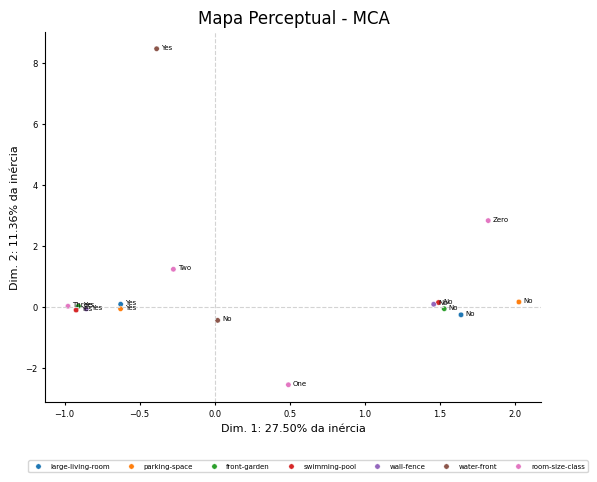

In [10]:
# Plotando o mapa perceptual (coordenadas-padrão)

chart = coord_padrao.reset_index()

var_chart = pd.Series(chart['index'].str.split('_', expand=True).iloc[:,0])
# Nota: para a função acima ser executada adequadamente, não deixar underline no nome original da variável no dataset!

nome_categ=[]
for col in casas_quali:
    nome_categ.append(casas_quali[col].sort_values(ascending=True).unique())
    categorias = pd.DataFrame(nome_categ).stack().reset_index()

chart_df_mca = pd.DataFrame({'categoria': chart['index'],
                             'obs_x': chart[0],
                             'obs_y': chart[1],
                             'variavel': var_chart,
                             'categoria_id': categorias[0]})

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.03, point['y'] - 0.02, point['val'], fontsize=5)

label_point(x = chart_df_mca['obs_x'],
            y = chart_df_mca['obs_y'],
            val = chart_df_mca['categoria_id'],
            ax = plt.gca())

sns.scatterplot(data=chart_df_mca, x='obs_x', y='obs_y', hue='variavel', s=15)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.axhline(y=0, color='lightgrey', ls='--', linewidth=0.8)
plt.axvline(x=0, color='lightgrey', ls='--', linewidth=0.8)
plt.tick_params(size=2, labelsize=6)
plt.legend(bbox_to_anchor=(1.1,-0.15), fancybox=True, shadow=False, ncols=7, fontsize='5')
plt.title("Mapa Perceptual - MCA", fontsize=12)
plt.xlabel(f"Dim. 1: {tabela_autovalores.iloc[0,1]} da inércia", fontsize=8)
plt.ylabel(f"Dim. 2: {tabela_autovalores.iloc[1,1]} da inércia", fontsize=8)
plt.show()

In [11]:
# Vamos criar o banco de dados com variáveis métricas

# Separando as variáveis originalmente métricas
casas_quanti = casas[['land_size_sqm',
                      'house_size_sqm',
                      'no_of_rooms',
                      'no_of_bathrooms',
                      'distance_to_school',
                      'house_age',
                      'distance_to_supermarket_km',
                      'crime_rate_index']]

# Adicionando as coordenadas das observações extraídas da ACM
casas_quanti = pd.concat([casas_quanti, coord_obs], axis=1)

In [12]:
# Teste de Esfericidade de Bartlett

bartlett, p_value = calculate_bartlett_sphericity(casas_quanti)

print(f'Qui² Bartlett: {round(bartlett, 2)}')
print(f'p-valor: {round(p_value, 4)}')

Qui² Bartlett: 37339.12
p-valor: 0.0


In [13]:
# Definindo a PCA (procedimento inicial com todos os fatores possíveis)

fa = FactorAnalyzer(n_factors=10, method='principal', rotation=None).fit(casas_quanti)

In [14]:
# Obtendo todos os possíveis autovalores

autovalores = fa.get_eigenvalues()[0]
print(autovalores)

# Soma dos autovalores
round(autovalores.sum(), 2)

[4.0410849  1.027185   1.01473555 1.00711342 0.9892809  0.96253178
 0.45721138 0.4111426  0.08113185 0.00858261]


np.float64(10.0)

In [15]:
# Aplicando o critério da raiz latente

sel_fator = sum(autovalores > 1)
print(f'Quantidade de fatores selecionados: {sel_fator}')

Quantidade de fatores selecionados: 4


In [16]:
# Redefinindo a PCA (critério da raiz latente)

fa = FactorAnalyzer(n_factors=sel_fator, method='principal', rotation=None).fit(casas_quanti)

In [17]:
# Eigenvalues, variâncias e variâncias acumuladas

autovalores_fatores = fa.get_factor_variance()

tabela_eigen = pd.DataFrame(autovalores_fatores)
tabela_eigen.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T

print(tabela_eigen)

         Autovalor  Variância  Variância Acumulada
Fator 1   4.041085   0.404108             0.404108
Fator 2   1.027185   0.102718             0.506827
Fator 3   1.014736   0.101474             0.608301
Fator 4   1.007113   0.100711             0.709012


In [18]:
# Determinando as cargas fatoriais

cargas_fatoriais = fa.loadings_

tabela_cargas = pd.DataFrame(cargas_fatoriais)
tabela_cargas.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = casas_quanti.columns

print(tabela_cargas)

                             Fator 1   Fator 2   Fator 3   Fator 4
land_size_sqm               0.951875 -0.007094  0.010473  0.012914
house_size_sqm              0.949457 -0.008913  0.010811  0.011206
no_of_rooms                 0.963547  0.011446 -0.006694 -0.011874
no_of_bathrooms             0.798642  0.005552 -0.004742  0.002089
distance_to_school         -0.011664  0.126432  0.637139 -0.319483
house_age                   0.006820 -0.068891  0.480943 -0.550164
distance_to_supermarket_km -0.003965  0.354536  0.509616  0.608264
crime_rate_index            0.013363  0.739787 -0.042701  0.082176
dim1_acm                   -0.816120 -0.012520  0.016249  0.031575
dim2_acm                    0.029461 -0.577083  0.339695  0.473488


In [20]:
# Determinando as comunalidades

comunalidades = fa.get_communalities()

tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = casas_quanti.columns

print(tabela_comunalidades)

                            Comunalidades
land_size_sqm                    0.906393
house_size_sqm                   0.901791
no_of_rooms                      0.928740
no_of_bathrooms                  0.637887
distance_to_school               0.524137
house_age                        0.538779
distance_to_supermarket_km       0.755405
crime_rate_index                 0.556040
dim1_acm                         0.667469
dim2_acm                         0.673476


In [21]:
# Extração dos fatores para as observações do banco de dados

fatores = pd.DataFrame(fa.transform(casas_quanti))
fatores.columns =  [f"Fator {i+1}" for i, v in enumerate(fatores.columns)]

# Adicionando os fatores ao banco de dados

casas = pd.concat([casas.reset_index(drop=True), fatores], axis=1)

In [22]:
# Identificando os scores fatoriais

scores = fa.weights_

tabela_scores = pd.DataFrame(scores)
tabela_scores.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_scores.columns)]
tabela_scores.index = casas_quanti.columns

print(tabela_scores)

                             Fator 1   Fator 2   Fator 3   Fator 4
land_size_sqm               0.235549 -0.006906  0.010321  0.012822
house_size_sqm              0.234951 -0.008677  0.010654  0.011127
no_of_rooms                 0.238438  0.011143 -0.006597 -0.011790
no_of_bathrooms             0.197631  0.005405 -0.004673  0.002074
distance_to_school         -0.002886  0.123086  0.627887 -0.317226
house_age                   0.001688 -0.067068  0.473959 -0.546278
distance_to_supermarket_km -0.000981  0.345153  0.502215  0.603968
crime_rate_index            0.003307  0.720208 -0.042081  0.081596
dim1_acm                   -0.201956 -0.012189  0.016013  0.031352
dim2_acm                    0.007290 -0.561810  0.334762  0.470144


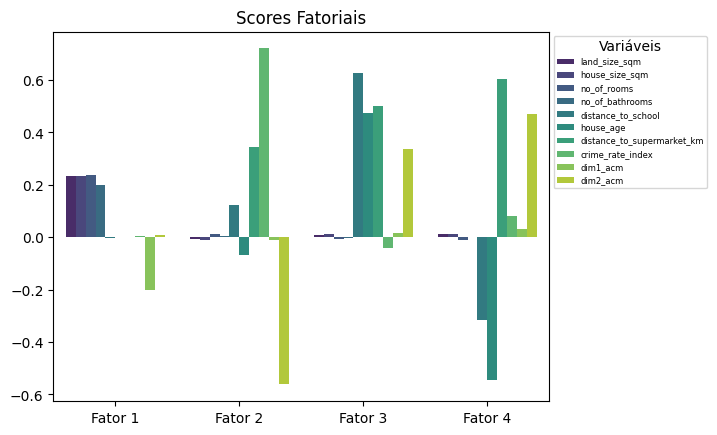

In [23]:
# Analisando os scores fatoriais em cada fator extraído

tabela_scores_graph = tabela_scores.reset_index()
tabela_scores_graph = tabela_scores_graph.melt(id_vars='index')

sns.barplot(data=tabela_scores_graph, x='variable', y='value', hue='index', palette='viridis')
plt.legend(title='Variáveis', bbox_to_anchor=(1,1), fontsize = '6')
plt.title('Scores Fatoriais', fontsize='12')
plt.xlabel(xlabel=None)
plt.ylabel(ylabel=None)
plt.show()

## Clustering K-Means com Dummização

In [35]:
df_dummie = pd.get_dummies(
    casas.drop(columns=['Fator 1', 'Fator 2', 'Fator 3', 'Fator 4']), 
    columns = casas.select_dtypes('object').columns, 
    dtype='int', 
    drop_first=True
)

In [36]:
df_dummie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   land_size_sqm               4954 non-null   int64  
 1   house_size_sqm              4954 non-null   int64  
 2   no_of_rooms                 4954 non-null   int64  
 3   no_of_bathrooms             4954 non-null   int64  
 4   distance_to_school          4954 non-null   float64
 5   house_age                   4954 non-null   int64  
 6   distance_to_supermarket_km  4954 non-null   float64
 7   crime_rate_index            4954 non-null   float64
 8   property_value              4954 non-null   int64  
 9   large_living_room_Yes       4954 non-null   int64  
 10  parking_space_Yes           4954 non-null   int64  
 11  front_garden_Yes            4954 non-null   int64  
 12  swimming_pool_Yes           4954 non-null   int64  
 13  wall_fence_Yes              4954 

In [37]:
df_dummie.describe()

,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,distance_to_school,house_age,distance_to_supermarket_km,crime_rate_index,property_value,large_living_room_Yes,parking_space_Yes,front_garden_Yes,swimming_pool_Yes,wall_fence_Yes,water_front_Yes,room_size_class_Three,room_size_class_Two,room_size_class_Zero
count,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000
mean,250.131409,231.250908,3.788252,3.199839,3.454219,11.444691,3.508639,2.986110,201974.738999,0.723860,0.763827,0.627574,0.617683,0.630400,0.048648,0.241825,0.359104,0.104360
std,103.131939,94.571642,1.585371,1.602300,2.007358,6.356991,1.991266,1.737742,90031.882219,0.447132,0.424772,0.483500,0.486003,0.482745,0.215152,0.428232,0.479786,0.305758
min,100.000000,85.000000,1.000000,1.000000,0.100000,1.000000,0.100000,0.010000,32622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,180.000000,165.000000,3.000000,2.000000,1.700000,6.000000,1.800000,1.470000,136777.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,235.000000,217.500000,4.000000,3.000000,3.400000,11.000000,3.500000,3.020000,194515.500000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,295.000000,274.000000,5.000000,4.000000,5.200000,17.000000,5.300000,4.490000,246590.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,796.000000,760.000000,8.000000,9.000000,6.900000,22.000000,6.900000,5.990000,692086.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
# Realizando a padronização por meio do Z-Score

# As variáveis estão em unidades de medidas distintas
df_dummie = df_dummie.apply(zscore, ddof=1)

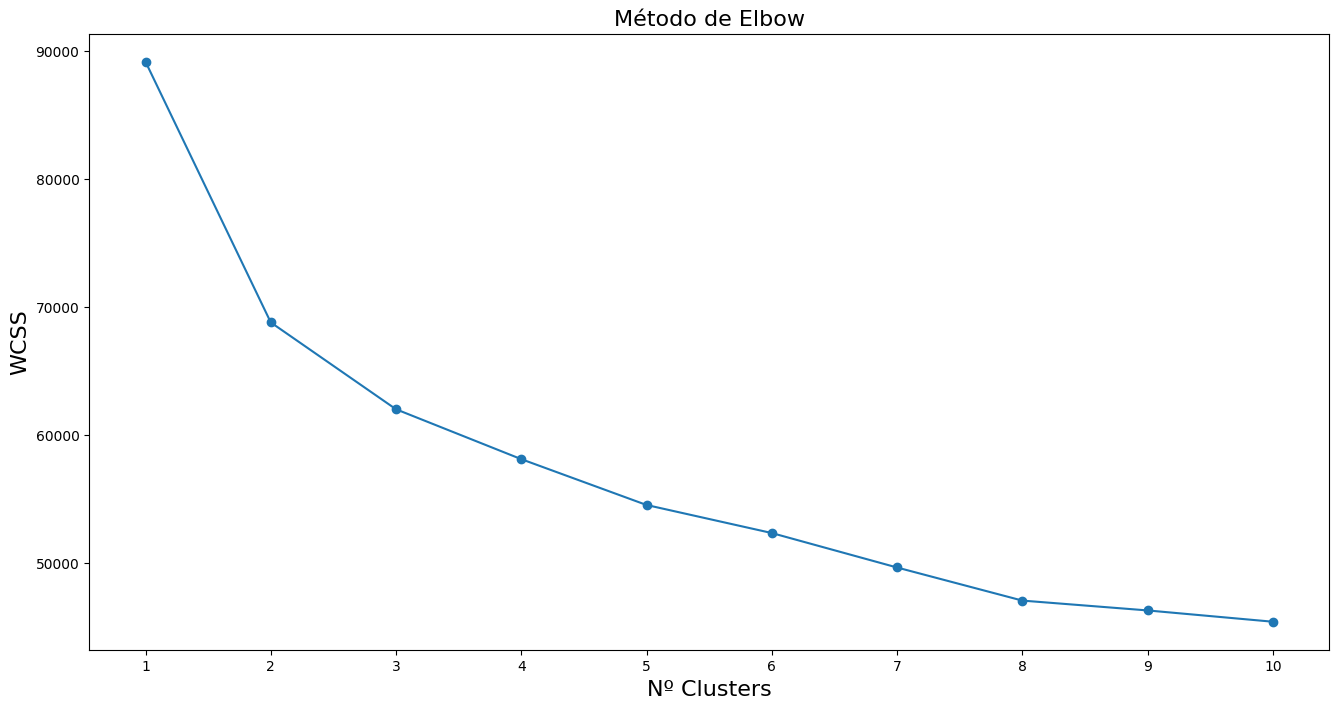

In [42]:
# Identificação da quantidade de clusters (Método Elbow)

elbow = []
K = range(1,11) # ponto de parada pode ser parametrizado manualmente
for k in K:
    kmeanElbow = KMeans(n_clusters=k, init='random', random_state=100).fit(df_dummie)
    elbow.append(kmeanElbow.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, elbow, marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.xticks(range(1,11)) # ajustar range
plt.ylabel('WCSS', fontsize=16)
plt.title('Método de Elbow', fontsize=16)
plt.show()

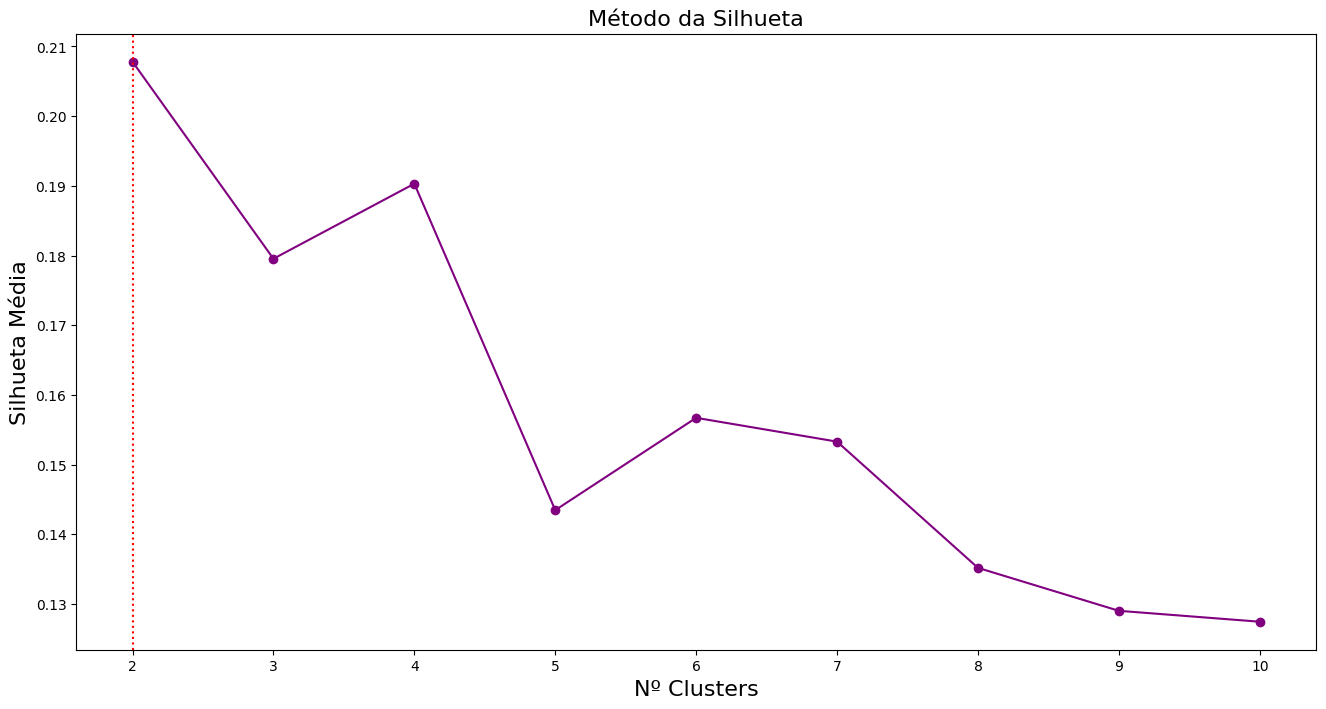

In [43]:
# Identificação da quantidade de clusters (Método da Silhueta)

silhueta = []
I = range(2,11) # ponto de parada pode ser parametrizado manualmente
for i in I: 
    kmeansSil = KMeans(n_clusters=i, init='random', random_state=100).fit(df_dummie)
    silhueta.append(silhouette_score(df_dummie, kmeansSil.labels_))

plt.figure(figsize=(16,8))
plt.plot(range(2, 11), silhueta, color = 'purple', marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.ylabel('Silhueta Média', fontsize=16)
plt.title('Método da Silhueta', fontsize=16)
plt.axvline(x = silhueta.index(max(silhueta))+2, linestyle = 'dotted', color = 'red') 
plt.show()

In [52]:
# Cluster K-means

# Vamos considerar 3 clusters, dadas as evidências anteriores!
kmeans_total = KMeans(n_clusters = 3, init = 'random', random_state=100).fit(df_dummie)

# Gerando a variável para identificarmos os clusters gerados
kmeans_clusters = kmeans_total.labels_
casas['Cluster'] = kmeans_clusters
casas['Cluster'] = casas['Cluster'].astype('category')
df_dummie['Cluster'] = kmeans_clusters
df_dummie['Cluster'] = df_dummie['Cluster'].astype('category')

In [53]:
for col in df_dummie.drop(columns='Cluster').columns:
    print(col)
    display(
        pg.anova(dv=col, 
        between='Cluster', 
        data=df_dummie,
        detailed=True).T
    )

land_size_sqm


,0,1
Source,Cluster,Within
SS,3797.62473,1155.37527
DF,2,4951
MS,1898.812365,0.233362
F,8136.767566,NaN
p-unc,0.0,NaN
np2,0.766732,NaN


house_size_sqm


,0,1
Source,Cluster,Within
SS,3751.942643,1201.057357
DF,2,4951
MS,1875.971322,0.242589
F,7733.131112,NaN
p-unc,0.0,NaN
np2,0.757509,NaN


no_of_rooms


,0,1
Source,Cluster,Within
SS,3842.078464,1110.921536
DF,2,4951
MS,1921.039232,0.224383
F,8561.419443,NaN
p-unc,0.0,NaN
np2,0.775707,NaN


no_of_bathrooms


,0,1
Source,Cluster,Within
SS,2494.262425,2458.737575
DF,2,4951
MS,1247.131213,0.496614
F,2511.267041,NaN
p-unc,0.0,NaN
np2,0.503586,NaN


distance_to_school


,0,1
Source,Cluster,Within
SS,2.261342,4950.738658
DF,2,4951
MS,1.130671,0.999947
F,1.130731,NaN
p-unc,0.322881,NaN
np2,0.000457,NaN


house_age


,0,1
Source,Cluster,Within
SS,5.181187,4947.818813
DF,2,4951
MS,2.590594,0.999357
F,2.592259,NaN
p-unc,0.074952,NaN
np2,0.001046,NaN


distance_to_supermarket_km


,0,1
Source,Cluster,Within
SS,7.097484,4945.902516
DF,2,4951
MS,3.548742,0.99897
F,3.552399,NaN
p-unc,0.028729,NaN
np2,0.001433,NaN


crime_rate_index


,0,1
Source,Cluster,Within
SS,1.578147,4951.421853
DF,2,4951
MS,0.789074,1.000085
F,0.789006,NaN
p-unc,0.454353,NaN
np2,0.000319,NaN


property_value


,0,1
Source,Cluster,Within
SS,3881.471013,1071.528987
DF,2,4951
MS,1940.735506,0.216427
F,8967.168975,NaN
p-unc,0.0,NaN
np2,0.783661,NaN


large_living_room_Yes


,0,1
Source,Cluster,Within
SS,1203.948599,3749.051401
DF,2,4951
MS,601.974299,0.757231
F,794.967696,NaN
p-unc,0.0,NaN
np2,0.243075,NaN


parking_space_Yes


,0,1
Source,Cluster,Within
SS,1717.874871,3235.125129
DF,2,4951
MS,858.937435,0.653429
F,1314.508426,NaN
p-unc,0.0,NaN
np2,0.346835,NaN


front_garden_Yes


,0,1
Source,Cluster,Within
SS,2068.57519,2884.42481
DF,2,4951
MS,1034.287595,0.582594
F,1775.313354,NaN
p-unc,0.0,NaN
np2,0.417641,NaN


swimming_pool_Yes


,0,1
Source,Cluster,Within
SS,2102.663994,2850.336006
DF,2,4951
MS,1051.331997,0.575709
F,1826.15127,NaN
p-unc,0.0,NaN
np2,0.424523,NaN


wall_fence_Yes


,0,1
Source,Cluster,Within
SS,1590.28146,3362.71854
DF,2,4951
MS,795.14073,0.6792
F,1170.702129,NaN
p-unc,0.0,NaN
np2,0.321074,NaN


water_front_Yes


,0,1
Source,Cluster,Within
SS,5.865038,4947.134962
DF,2,4951
MS,2.932519,0.999219
F,2.93481,NaN
p-unc,0.053233,NaN
np2,0.001184,NaN


room_size_class_Three


,0,1
Source,Cluster,Within
SS,300.597178,4652.402822
DF,2,4951
MS,150.298589,0.93969
F,159.944945,NaN
p-unc,0.0,NaN
np2,0.06069,NaN


room_size_class_Two


,0,1
Source,Cluster,Within
SS,51.401974,4901.598026
DF,2,4951
MS,25.700987,0.990022
F,25.960021,NaN
p-unc,0.0,NaN
np2,0.010378,NaN


room_size_class_Zero


,0,1
Source,Cluster,Within
SS,333.458023,4619.541977
DF,2,4951
MS,166.729011,0.933052
F,178.69203,NaN
p-unc,0.0,NaN
np2,0.067324,NaN


In [54]:
# Selecionando apenas variáveis significativas (p-unc <= 0.05)
significant_columns = ['house_size_sqm', 'no_of_rooms', 'no_of_bathrooms',
                       'property_value', 'large_living_room_Yes',
                       'parking_space_Yes', 'front_garden_Yes',
                       'swimming_pool_Yes', 'wall_fence_Yes']

df_significant = df_dummie[significant_columns]

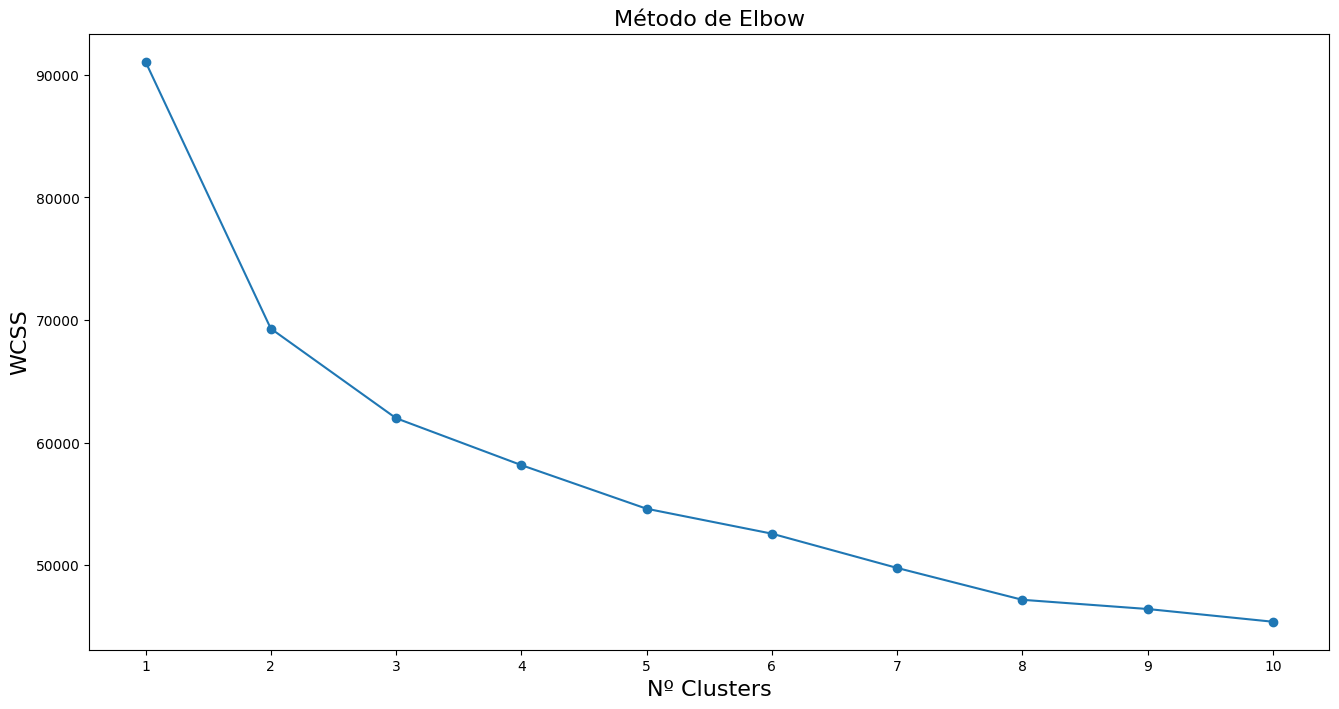

In [55]:
# Identificação da quantidade de clusters (Método Elbow)

elbow = []
K = range(1,11) # ponto de parada pode ser parametrizado manualmente
for k in K:
    kmeanElbow = KMeans(n_clusters=k, init='random', random_state=100).fit(df_dummie)
    elbow.append(kmeanElbow.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, elbow, marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.xticks(range(1,11)) # ajustar range
plt.ylabel('WCSS', fontsize=16)
plt.title('Método de Elbow', fontsize=16)
plt.show()

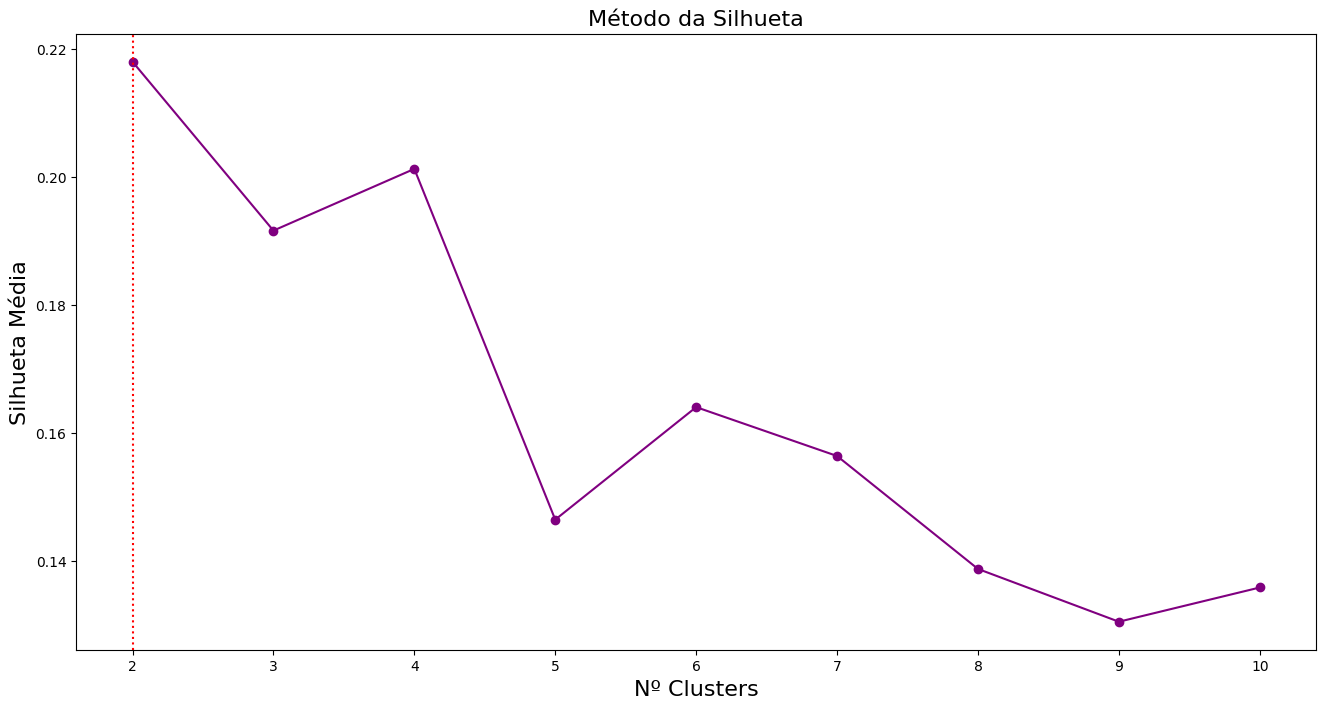

In [56]:
# Identificação da quantidade de clusters (Método da Silhueta)

silhueta = []
I = range(2,11) # ponto de parada pode ser parametrizado manualmente
for i in I: 
    kmeansSil = KMeans(n_clusters=i, init='random', random_state=100).fit(df_dummie)
    silhueta.append(silhouette_score(df_dummie, kmeansSil.labels_))

plt.figure(figsize=(16,8))
plt.plot(range(2, 11), silhueta, color = 'purple', marker='o')
plt.xlabel('Nº Clusters', fontsize=16)
plt.ylabel('Silhueta Média', fontsize=16)
plt.title('Método da Silhueta', fontsize=16)
plt.axvline(x = silhueta.index(max(silhueta))+2, linestyle = 'dotted', color = 'red') 
plt.show()

In [57]:
# Aplicando K-Means com as variáveis significativas
kmeans_sem_vars = KMeans(n_clusters=3, init='random', random_state=100).fit(df_significant)

# Gerando os clusters novamente
df_significant['Cluster'] = kmeans_sem_vars.labels_

C:\Users\guilh\AppData\Local\Temp\ipykernel_25196\3369309855.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['Cluster'] = kmeans_sem_vars.labels_


In [58]:
df_significant

,house_size_sqm,no_of_rooms,no_of_bathrooms,property_value,large_living_room_Yes,parking_space_Yes,front_garden_Yes,swimming_pool_Yes,wall_fence_Yes,Cluster
0,-0.573649,-0.497203,-1.372926,-0.405887,-1.618893,0.555998,0.770272,-1.270945,0.765622,2
1,-0.520779,0.133564,-0.124720,-0.165849,0.617581,0.555998,-1.297981,0.786657,0.765622,1
2,-0.520779,0.133564,0.499383,-0.592198,0.617581,0.555998,-1.297981,0.786657,-1.305864,1
3,-0.689963,-1.127971,-0.124720,-0.868467,-1.618893,0.555998,-1.297981,-1.270945,-1.305864,2
4,-0.700537,-0.497203,-1.372926,-0.505429,0.617581,0.555998,-1.297981,-1.270945,0.765622,2
...,...,...,...,...,...,...,...,...,...,...
4949,0.314567,0.133564,0.499383,0.376614,0.617581,0.555998,0.770272,0.786657,0.765622,1
4950,0.536621,0.133564,-0.748823,0.988764,0.617581,0.555998,0.770272,0.786657,0.765622,1
4951,-0.890869,-0.497203,0.499383,-1.061254,0.617581,0.555998,-1.297981,-1.270945,0.765622,2
4952,-0.774555,-1.127971,-1.372926,-1.048470,-1.618893,0.555998,-1.297981,0.786657,-1.305864,2


In [59]:
print("Inertia Com Todas:", kmeans_total.inertia_)
print("Inertia Sem Vars:", kmeans_sem_vars.inertia_)

Inertia Com Todas: 61995.83623719836
Inertia Sem Vars: 21856.4795433967


*A inércia mede a compactação dos clusters. Menores valores indicam clusters mais coesos.*

In [60]:
score_total = silhouette_score(df_dummie.drop(columns='Cluster'), df_dummie['Cluster'])
score_sem_vars = silhouette_score(df_significant.drop(columns='Cluster'), df_significant['Cluster'])
print("Silhouette Score Total:", score_total)
print("Silhouette Score Sem Vars:", score_sem_vars)

Silhouette Score Total: 0.17953520165435188
Silhouette Score Sem Vars: 0.31900425646544417


*O Silhouette Score mede a separação entre os clusters. Valores próximos de 1 indicam boa separação.*

**O melhor modelo seria o modelo sem as variáveis com menor significância estatística com a criação dos clusters!!**
- *Entretanto é importante observar que, se as variáveis tiverem relevância para o contexto do negócio é importante considerar se vale a pena excluir ela, pois a dimensão excluida pode ser importante para o escopo da análise na prática, por exemplo, estão sendo analisados imóveis na praia, e a variável waterfront não possui significância estatística com a criação dos clusters, deve ser avaliado se vale a pena excluí-la dada a importância prática desta característica de uma residência na praia.*